In [ ]:
!git pull origin main

In [1]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.9 MB/s eta 0:00:00:00:0100:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Matplotlib is building the font cache; this may take a moment.


In [3]:
DATA_BUCKET = 'trainer-injury'
data_key = 'full_model_df.csv'
data_location = 's3://{}/{}'.format(DATA_BUCKET, data_key) 
df = pd.read_csv(data_location) 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [4]:
df.head(2)

,trainer_id,n_entries_365,unique_horses_365,scratched_365,dnf_365,xDNF_365,min_age_365,lasix_365,bute_365,days_since_last_race_min_365,...,dnf_per_entry_30,dnf_smoothed_30,dnfAA_30,badly_beaten_pct_30,lasix_pct_30,bute_pct_30,first_long_age_30,lognorm_p1_30,lognorm_p2_30,lognorm_p3_30
0,0,219.0,214.0,219.0,0.0,0.000000,2.150684,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,143.0,13.0,21.0,7.0,11.395786,4.013698,143.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cols30 = [c for c in df.columns if '30' in c]
cols90 = [c for c in df.columns if '90' in c]
cols180 = [c for c in df.columns if '180' in c]
cols365 = [c for c in df.columns if '365' in c]
merge_cols = ['trainer_id'] + [c for c in df.columns if 'target' in c]

In [6]:
d365 = df[cols365 + merge_cols].dropna(subset=['unique_horses_365'])
d180 = df[cols180 + merge_cols].dropna(subset=['unique_horses_180'])
d90 = df[cols90 + merge_cols].dropna(subset=['unique_horses_90'])
d30 = df[cols30 + merge_cols].dropna(subset=['unique_horses_30'])

d = d365.merge(d180, how='inner', on=merge_cols)
d = d.merge(d90, how='inner', on=merge_cols)
d = d.merge(d30, how='inner', on=merge_cols)
d.head(2)

,n_entries_365,unique_horses_365,scratched_365,dnf_365,xDNF_365,min_age_365,lasix_365,bute_365,days_since_last_race_min_365,days_since_last_race_median_365,...,dnf_per_entry_30,dnf_smoothed_30,dnfAA_30,badly_beaten_pct_30,lasix_pct_30,bute_pct_30,first_long_age_30,lognorm_p1_30,lognorm_p2_30,lognorm_p3_30
0,219.0,214.0,219.0,0.0,0.000000,2.150684,0.0,0.0,0.0,21.0,...,0.000000,0.035325,0.000000,0.0,0.0,0.0,4.417808,0.00000,-2097151.0,2.097166e+06
1,143.0,13.0,21.0,7.0,11.395786,4.013698,143.0,0.0,0.0,16.0,...,0.083333,0.115467,-0.074532,0.0,1.0,0.0,7.916438,14.08949,2.0,2.133000e-02


In [170]:
d_backup = d.copy()

In [8]:
d.to_csv(f's3://{DATA_BUCKET}/fixed_full_model_df.csv', index=False)

In [167]:
d2 = d[d['target_n_entries'] > 100]

In [184]:
d = d_backup.copy()

In [527]:
print([c for c in df.columns if 'target' in c])
print()
print([c for c in df.columns if '365' in c])
print()
print([ c for c in df.columns if 'distance' in c])
print()
print([ c for c in df.columns if 'age' in c])
print()
print([ c for c in df.columns if 'lognorm' in c])
print()
print([ c for c in df.columns if 'badly_beaten' in c])

['target_n_entries', 'target', 'target_dnf_smoothed']

['n_entries_365', 'unique_horses_365', 'scratched_365', 'dnf_365', 'xDNF_365', 'min_age_365', 'lasix_365', 'bute_365', 'days_since_last_race_min_365', 'days_since_last_race_median_365', 'rest_after_dnf_median_365', 'rest_after_scratch_median_365', 'distance_jump_365', 'surface_changes_365', 'long_layoffs_365', 'badly_beaten_365', 'scratches_per_entry_365', 'dnf_per_entry_365', 'dnf_smoothed_365', 'dnfAA_365', 'badly_beaten_pct_365', 'lasix_pct_365', 'bute_pct_365', 'first_long_age_365', 'lognorm_p1_365', 'lognorm_p2_365', 'lognorm_p3_365']

['distance_jump_365', 'distance_jump_180', 'distance_jump_90', 'distance_jump_30']

['min_age_365', 'first_long_age_365', 'min_age_180', 'first_long_age_180', 'min_age_90', 'first_long_age_90', 'min_age_30', 'first_long_age_30']

['lognorm_p1_365', 'lognorm_p2_365', 'lognorm_p3_365', 'lognorm_p1_180', 'lognorm_p2_180', 'lognorm_p3_180', 'lognorm_p1_90', 'lognorm_p2_90', 'lognorm_p3_90', 'lognorm

In [186]:
from models.model_builds import build_linear_regressor, build_xgb_regressor
from baseline_model.preprocessing import create_train_test_split
from models.eval import evaluate_regression

In [600]:
COLS_FOR_MODEL = [
    'dnf_smoothed_365', 
    'dnf_smoothed_180', 
    'dnf_smoothed_90', 
    'dnf_smoothed_30',
   # 'distance_jump_365', 
    #'distance_jump_180', 
    #'distance_jump_90', 
    #'distance_jump_30',
    #'min_age_365', 
    #'first_long_age_365', 
    #'min_age_180', 
   # 'first_long_age_180', 
    #'min_age_90', 
   # 'first_long_age_90', 
    #'min_age_30', 
   #'first_long_age_30',
    #'lognorm_p1_365', 
    #'lognorm_p2_365', 
    #'lognorm_p3_365', 
    #'lognorm_p1_180', 
    #'lognorm_p2_180', 
    #'lognorm_p3_180', 
    #'lognorm_p1_90', 
    #'lognorm_p2_90', 
    #'lognorm_p3_90', 
    #'lognorm_p1_30', 
    #'lognorm_p2_30', 
    #'lognorm_p3_30',
    #'badly_beaten_pct_365',
    #'badly_beaten_pct_180',
    #'badly_beaten_pct_90',
    #'badly_beaten_pct_30'
] + [
   # c for c in df.columns if 'scratch' in c    
] +   [
   #     c for c in df.columns if 'AA' in c    
] + [
    c for c in df.columns if 'lasix_pct' in c
] + [
 #   c for c in df.columns if 'bute_pct' in c
] + [
    c for c in df.columns if 'rest' in c
] + [
    c for c in df.columns if 'badly_beaten_pct' in c
] + [
    c for c in df.columns if 'lognorm' in c
] + [
   c for c in df.columns if 'age' in c
] + [
  #   c for c in df.columns if 'distance' in c
] + [
     c for c in df.columns if 'surface' in c
] + [
  #   c for c in df.columns if 'layoff' in c
]


# dnf smooth 365
# badly beaten could help
# log norm could help (but sends linear model crazy)
# distance probably helps
# age def helps




TARGET = 'target_dnf_smoothed'
COLS_FOR_MODEL += [TARGET , 'trainer_id']

In [601]:
# d[COLS_FOR_MODEL].corr()

In [602]:
d.shape

(14335, 112)

In [615]:
data = create_train_test_split(d[COLS_FOR_MODEL], 0.2, 0.15, 'trainer_id', TARGET)
data_no_na = data.copy()
data_no_na['X_train'] = data_no_na['X_train'].fillna(0)
data_no_na['X_test'] = data_no_na['X_test'].fillna(0)
data_no_na['X_valid'] = data_no_na['X_valid'].fillna(0)

KeyError: 'trainer_id'

In [604]:
lr = build_linear_regressor(data_no_na)
xgb = build_xgb_regressor(data, alpha=0.1, max_depth=5)

In [605]:
metrics = []
for model in [lr, xgb]:
    for dset in ['train', 'test', 'valid']:
        X = data[f'X_{dset}']
        y = data[f'y_{dset}']
        try:
            y_pred = model.predict(X)
        except:
            y_pred = model.predict(X.fillna(0))

        metric = evaluate_regression(y, y_pred)
        metric['model'] = model.__class__.__name__
        metric['dataset'] = dset
        metric = {'model': metric.pop('model'), 'dataset': metric.pop('dataset'), **metric}
        metrics.append(metric)  

metrics = pd.DataFrame(metrics)
metrics

,model,dataset,r2,mse,mae
0,LassoCV,train,0.000671,0.004726,0.047275
1,LassoCV,test,-0.002630,0.006347,0.054926
2,LassoCV,valid,-0.002938,0.005108,0.049402
3,XGBRegressor,train,0.612564,0.001832,0.029337
4,XGBRegressor,test,0.267318,0.004638,0.050196
5,XGBRegressor,valid,0.274546,0.003695,0.044587


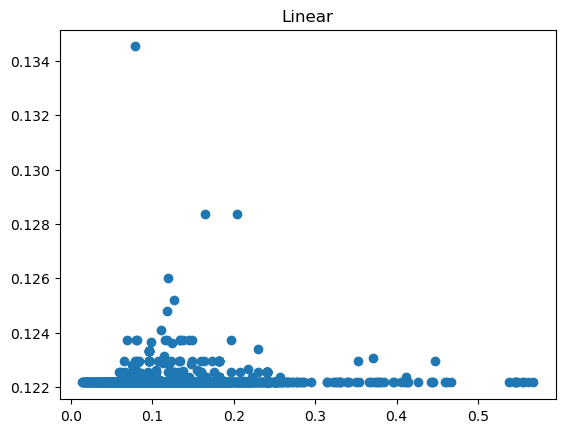

In [606]:
plt.scatter(data['y_valid'], lr.predict(data['X_valid'].fillna(0)))
plt.title('Linear')
plt.show()

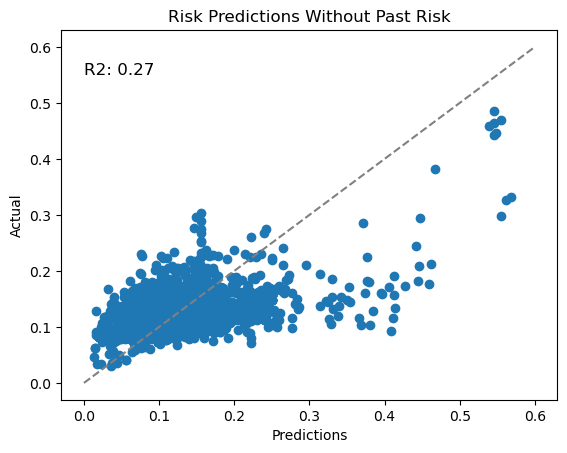

In [610]:
plt.scatter(data['y_valid'], xgb.predict(data['X_valid']))
plt.title('Risk Predictions Without Past Risk')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot([0, 0.6], [0, 0.6], color='gray', linestyle='--')
plt.text(0.0, 0.55, f'R2: {round(r2_score(data["y_valid"], xgb.predict(data["X_valid"])), 2)}', fontsize=12)

plt.show()

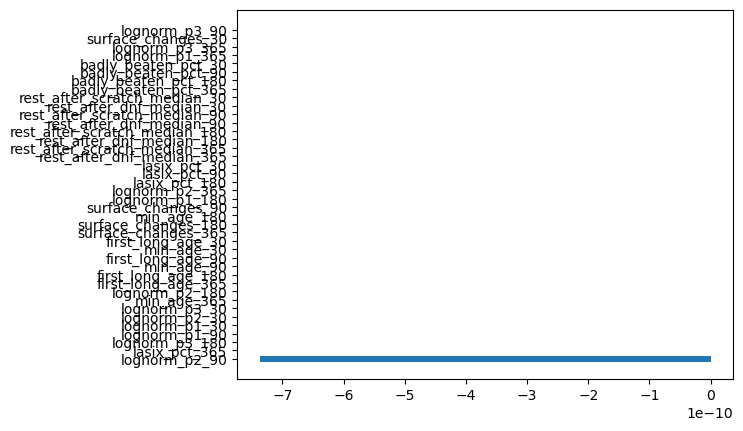

In [608]:
ft_imp = []
for col, coef in zip(lr.feature_names_in_, lr.coef_):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()


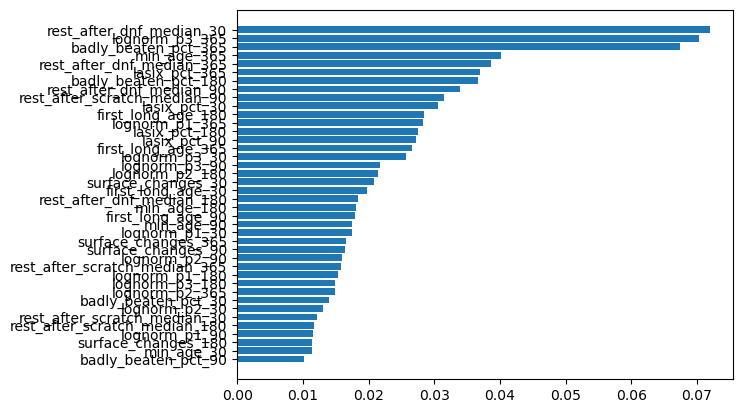

In [609]:
ft_imp = []
for col, coef in zip(xgb.feature_names_in_, xgb.feature_importances_):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()

In [623]:
import boto3 
import numpy as np
import pickle

In [561]:
#s3_resource = boto3.resource('s3')
#pickle_byte_obj = pickle.dumps(xgb)
#s3_resource.Object('trainer-injury','trainer_risk_6mo_xgb_model.pkl').put(Body=pickle_byte_obj)

{'ResponseMetadata': {'RequestId': 'WPZ3JDEQXPY7DACB',
  'HostId': 'tLci+TbYUmA8V3djdl46RhQdF717gwHa4dW1xZ/Xx/N3rpg9vAJsUXsyXLmFgjIt4lPvSrxY2Ws=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'tLci+TbYUmA8V3djdl46RhQdF717gwHa4dW1xZ/Xx/N3rpg9vAJsUXsyXLmFgjIt4lPvSrxY2Ws=',
   'x-amz-request-id': 'WPZ3JDEQXPY7DACB',
   'date': 'Tue, 11 Jun 2024 01:01:54 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"5928adefb4ccb96a532e5aea18d1f0ec"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"5928adefb4ccb96a532e5aea18d1f0ec"',
 'ServerSideEncryption': 'AES256'}

In [612]:
xgb = pickle.loads(s3_resource.Bucket("trainer-injury").Object("trainer_risk_6mo_xgb_model.pkl").get()['Body'].read())

In [619]:
preds = []
for dset in ['train', 'test', 'valid']:
    X = data[f'X_{dset}']
    y_pred = list(xgb.predict(d[xgb.feature_names_in_]))
    preds += y_pred

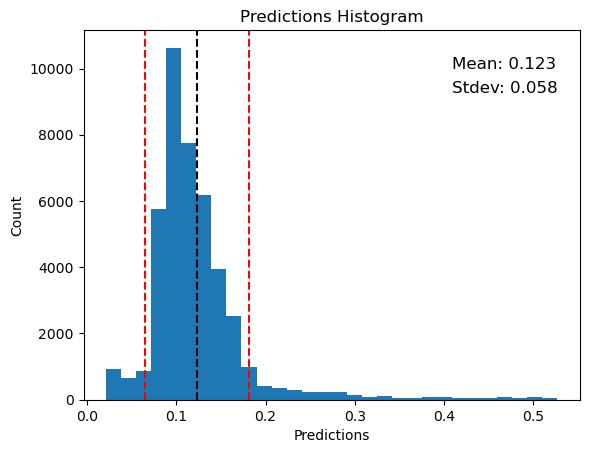

In [637]:
plt.figure()
plt.hist(preds, bins=30)
# vertical black dotted line for mean
plt.axvline(np.mean(preds), color='black', linestyle='--')
# red dotted lines at +1 and -1 stdev 
plt.axvline(np.mean(preds) + np.std(preds), color='red', linestyle='--')
plt.axvline(np.mean(preds) - np.std(preds), color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.title('Predictions Histogram')

plt.text(0.7, 0.8, f'Mean: {np.mean(preds):.3f}', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.7, 0.75, f'Stdev: {np.std(preds):.3f}', fontsize=12, transform=plt.gcf().transFigure)
plt.show()